# Deep Computer Vision Using Convolutional Neural Networks

In [1]:
import sys

assert sys.version_info >= (3, 7)

In [2]:
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

In [3]:
import tensorflow as tf

assert version.parse(tf.__version__) >= version.parse("2.8.0")

In [4]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [5]:
# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. Neural nets can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware "
              "accelerator.")
    if IS_KAGGLE:
        print("Go to Settings > Accelerator and select GPU.")

No GPU was detected. Neural nets can be very slow without a GPU.


# Convolutional Layers

Neurons in the first convolutional layer are not connected to every single pixle in the input image, but only to pixels in their receptive fields. In turn, each neuron in the second convolutional layer is connected only to neurons located within a small rectangle in the first layer. This architecture allows the network to conecntrate on small low-level features in the first hidden layer, then assemble them into larger higher-level features in the next hidden layer, and so on. This hierarchical structure is common in real-world images, which is one of the reasons why CNNs work so well for image recognition.

Note that in a CNN, each layer is represented in 2D, which makes it easier to match neurons with their corresponding inputs.

A layer full of neurons using the same filter outputs a *feature map*, which highlights the areas in an image that activate the filter the most! During training, the convolutional layer will automatically learn the most useful filters for its task, and the layers above will learn to combine them into more complex patterns.

## Implementing Convolutional Layers with Keras

Let's load two sample images, rescale their pixel values to 0-1, and center crop them to small 70×120 images:

In [7]:
from sklearn.datasets import load_sample_images
import tensorflow as tf

images = load_sample_images()["images"]
images = tf.keras.layers.CenterCrop(height=70, width=120)(images)
images = tf.keras.layers.Rescaling(scale=1 / 255)(images)

In [8]:
images.shape

TensorShape([2, 70, 120, 3])

The 4 dimensions above are
1. "2" for the 2 sample images
2. "70" the height of the sample images
3. "120" the width of the sample images
4. "3" for the color (RGB) channels of each image.

In [ ]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
# 32 filters, each with 7 x 7
conv_layer = tf.keras.layers.Conv2D(filters=32, kernel_size=7)
fmaps = conv_layer(images)

In [10]:
fmaps.shape

TensorShape([2, 64, 114, 32])

The second and 3rd dimension have shrunk since by default Conv2D layer does not use any zero-padding, hence we lose 6 pixels both horizontally and vertically.

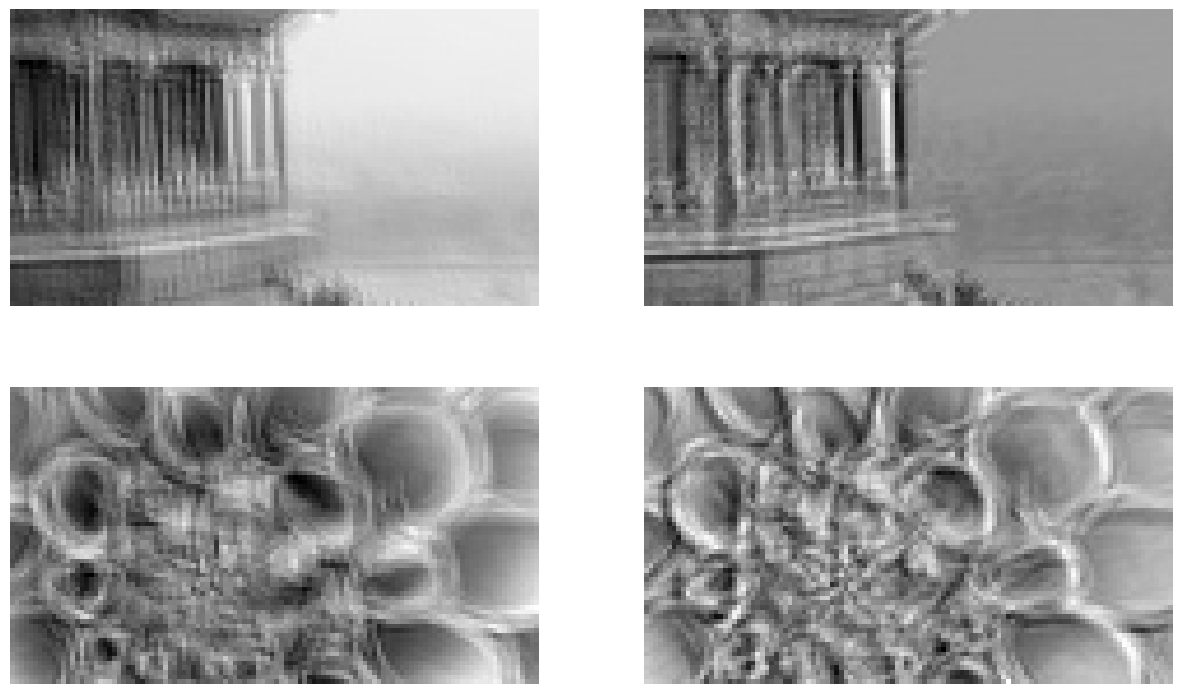

In [11]:
# extra code – displays the two output feature maps for each image

plt.figure(figsize=(15, 9))
for image_idx in (0, 1):
    for fmap_idx in (0, 1):
        plt.subplot(2, 2, image_idx * 2 + fmap_idx + 1)
        plt.imshow(fmaps[image_idx, :, :, fmap_idx], cmap="gray")
        plt.axis("off")

plt.show()

As you can see, randomly generated filters typically act like edge detectors, which is great since that's a useful tool in image processing, and that's the type of filters that a convolutional layer typically starts with. Then, during training, it gradually learns improved filters to recognize useful patterns for the task.

For zero-padding:

In [12]:
conv_layer = tf.keras.layers.Conv2D(filters=32, kernel_size=7,
                                    padding="same")
fmaps = conv_layer(images)

In [13]:
fmaps.shape

TensorShape([2, 70, 120, 32])

In [14]:
# extra code – shows that the output shape when we set strides=2
conv_layer = tf.keras.layers.Conv2D(filters=32, kernel_size=7, padding="same",
                                    strides=2)
fmaps = conv_layer(images)
fmaps.shape

TensorShape([2, 35, 60, 32])

In [15]:
# extra code – this utility function can be useful to compute the size of the
#              feature maps output by a convolutional layer. It also returns
#              the number of ignored rows or columns if padding="valid", or the
#              number of zero-padded rows or columns if padding="same"."""

import numpy as np

def conv_output_size(input_size, kernel_size, strides=1, padding="valid"):
    if padding=="valid":
        z = input_size - kernel_size + strides
        output_size = z // strides
        num_ignored = z % strides
        return output_size, num_ignored
    else:
        output_size = (input_size - 1) // strides + 1
        num_padded = (output_size - 1) * strides + kernel_size - input_size
        return output_size, num_padded

conv_output_size(np.array([70, 120]), kernel_size=7, strides=2, padding="same")

(array([35, 60]), array([5, 5]))

In [19]:
kernels, biases = conv_layer.get_weights()
kernels.shape

(7, 7, 3, 32)

`kernels` array is 4D with shape [*kernel_height*, *kernel_width*, *input_channels*, *output_channels*]

In [20]:
biases.shape

(32,)

In [21]:
# extra code – shows how to use the tf.nn.conv2d() operation

tf.random.set_seed(42)
filters = tf.random.normal([7, 7, 3, 2])
biases = tf.zeros([2])
fmaps = tf.nn.conv2d(images, filters, strides=1, padding="SAME") + biases

Let's manually create two filters full of zeros, except for a vertical line of 1s in the first filter, and a horizontal one in the second filter (just like in Figure 14–5). The two output feature maps highlight vertical lines and horizontal lines, respectively. In practice you will probably never need to create filters manually, since the convolutional layers will learn them automatically.

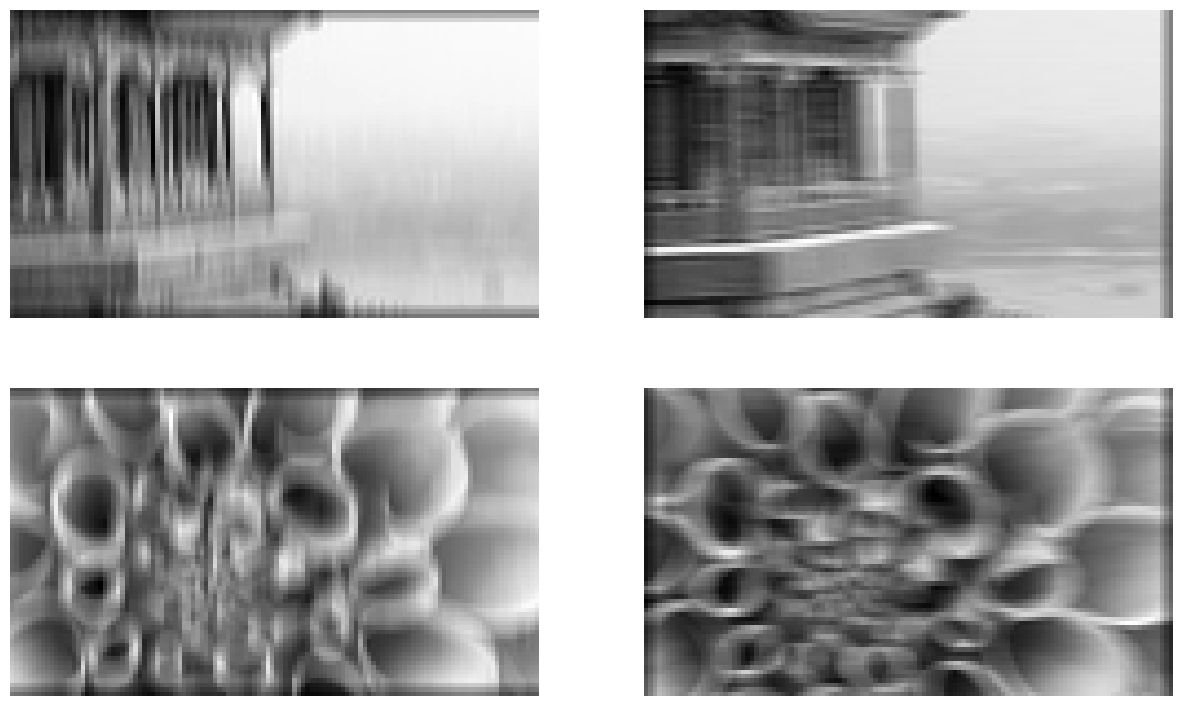

In [22]:
# extra code – shows how to manually create two filters to get images similar
#              to those in Figure 14–5.

plt.figure(figsize=(15, 9))
filters = np.zeros([7, 7, 3, 2])
filters[:, 3, :, 0] = 1
filters[3, :, :, 1] = 1
fmaps = tf.nn.conv2d(images, filters, strides=1, padding="SAME") + biases

for image_idx in (0, 1):
    for fmap_idx in (0, 1):
        plt.subplot(2, 2, image_idx * 2 + fmap_idx + 1)
        plt.imshow(fmaps[image_idx, :, :, fmap_idx], cmap="gray")
        plt.axis("off")

plt.show()

Notice the dark lines at the top and bottom of the two images on the left, and on the left and right of the two images on the right? Can you guess what these are? Why were they not present in the previous figure?

You guessed it! These are artifacts due to the fact that we used zero padding in this case, while we did not use zero padding to create the feature maps in the previous figure. Because of zero padding, the two feature maps based on the vertical line filter (i.e., the two left images) could not fully activate near the top and bottom of the images. Similarly, the two feature maps based on the horizontal line filter (i.e., the two right images) could not fully activate near the left and right of the images.

## Pooling Layers

*subsampling* the input image in order to reduce the computational load, the memory usage and the number of parameters.

Pooling neuron have no weight, and all it does is aggregate the inputs using an aggregation function such as the max or mean.

### Implementing Pooling Layers with Keras

In [23]:
max_pool = tf.keras.layers.MaxPool2D(pool_size=2)

In [24]:
output = max_pool(images)

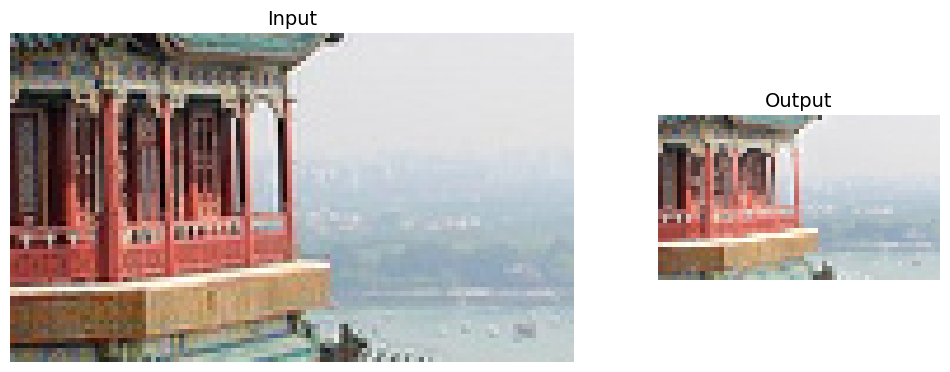

In [25]:
# extra code – this cells shows what max pooling with stride = 2 looks like

import matplotlib as mpl

fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input")
ax1.imshow(images[0])  # plot the 1st image
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output")
ax2.imshow(output[0])  # plot the output for the 1st image
ax2.axis("off")
plt.show()

Most of the time, max pooling is preferred since they generally perform better. This is because max pooling preserves only the strongest features, getting rid of all the meaningless ones, so the next layers get a cleaner signal to work with!

**Depth-wise Pooling**

In [35]:
# extra code – shows how to use the max_pool() op; only works on the CPU
np.random.seed(42)
fmaps = np.random.rand (2, 70, 120, 60)
with tf.device("/cpu:0"):
    output = tf.nn.max_pool(fmaps, ksize=(1, 1, 1, 3), strides=(1, 1, 1, 3),
                            padding="VALID")
output.shape

TensorShape([2, 70, 120, 20])

In [36]:
class DepthPool(tf.keras.layers.Layer):
    def __init__(self, pool_size=2, **kwargs):
        super().__init__(**kwargs)
        self.pool_size = pool_size
    
    def call(self, inputs):
        shape = tf.shape(inputs)  # shape[-1] is the number of channels
        groups = shape[-1] // self.pool_size  # number of channel groups
        new_shape = tf.concat([shape[:-1], [groups, self.pool_size]], axis=0)
        return tf.reduce_max(tf.reshape(inputs, new_shape), axis=-1)

In [37]:
# extra code – shows that this custom layer gives the same result as max_pool()
np.allclose(DepthPool(pool_size=3)(fmaps), output)

True

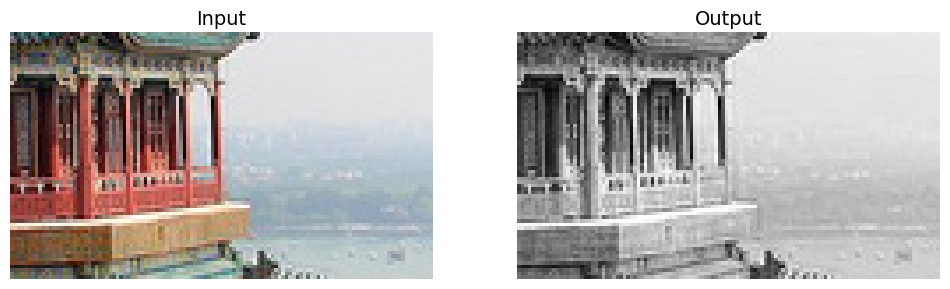

In [ ]:
# extra code – computes and displays the output of the depthwise pooling layer

depth_output = DepthPool(pool_size=3)(images)

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.title("Input")
plt.imshow(images[0])  # plot the 1st image
plt.axis("off")
plt.subplot(1, 2, 2)
plt.title("Output")
plt.imshow(depth_output[0, ..., 0], cmap="gray")  # plot 1st image's output
plt.axis("off")
plt.show()

**Global Average Pooling**

Compute the mean of each entire feature map (like an average pooling layer using a pooling kernel with the same spatial dimensions as the inputs), this means that it just outputs a single number per feature map and per instance. While this is extremely destructive, it can be useful just before the output layer!

In [32]:
global_avg_pool = tf.keras.layers.GlobalAvgPool2D()

In [ ]:
# the code above is the same as below
global_avg_pool = tf.keras.layers.Lambda(
    lambda X: tf.reduce_mean(X, axis=[1, 2]))

In [34]:
global_avg_pool(images)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.64338624, 0.5971759 , 0.5824972 ],
       [0.76306933, 0.2601113 , 0.10849128]], dtype=float32)>

In this case, under each image, we have 1 number for each channel.

## CNN Architectures

Typically, it will stack a few convolutional layers, then a pooling layer, then another few convolutional layers (+ReLU), then another pooling layer, and so on.
At the top of the stack, a regular feedforward neural network is added, composed of few fully connected layers (+ReLUs), and the final layer outputs the prediction (e.g. a softmax layer that outputs estimated class probabilities).

It is recommended to use convolution kernels that are not too large, except for the first convolutional layer, which typically have a large kernel (e.g. 5 x 5) with a stride of 2 or more as this will reduce the spatial dimension of the image without losing too much information and since the input image only has 3 channels in general, it wil not be too costly.

In [49]:
# extra code – loads the mnist dataset, add the channels axis to the inputs,
#              scales the values to the 0-1 range, and splits the dataset
mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = mnist
X_train_full = np.expand_dims(X_train_full, axis=-1).astype(np.float32) / 255
X_test = np.expand_dims(X_test.astype(np.float32), axis=-1) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

In [ ]:
from functools import partial

# use functools.partial() to define DefaultConv2D
DefaultConv2D = partial(tf.keras.layers.Conv2D, kernel_size=3, padding="same",
                        activation="relu", kernel_initializer="he_normal")

# create a sequential model.
model = tf.keras.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[28,28,1]),
    tf.keras.layers.MaxPool2D(),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    tf.keras.layers.MaxPool2D(),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    tf.keras.layers.MaxPool2D(),
    # flatten the layers BEFORE putting into the first dense layer
    tf.keras.layers.Flatten(),
    # 2 hidden dense layers with dropout layers to avoid overfitting
    tf.keras.layers.Dense(units=128, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=64, activation="relu",
                           kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    # 1 output layer with 10 classes
    tf.keras.layers.Dense(units=10, activation="softmax")
])

Note that the number of filters doubles as we climb up the CNN toward the output layer as there are often low number of low-level features but many different ways to combine them into higher-level features. So it is common practice to double the number of filters after each pooling layer: since a pooling layer divides each spatial dimension by a factor of 2, we can afford to double the number of feature maps in the next layer WITHOUT fear of exploding the number of parameters,memory usage, or computational load.

In [50]:
# extra code – compiles, fits, evaluates, and uses the model to make predictions
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))
score = model.evaluate(X_test, y_test)
X_new = X_test[:10]  # pretend we have new images
y_pred = model.predict(X_new)

Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 106s 61ms/step - accuracy: 0.6077 - loss: 1.0945 - val_accuracy: 0.8682 - val_loss: 0.3843
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 100s 58ms/step - accuracy: 0.8519 - loss: 0.4447 - val_accuracy: 0.8906 - val_loss: 0.3112
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 102s 59ms/step - accuracy: 0.8771 - loss: 0.3703 - val_accuracy: 0.8918 - val_loss: 0.2906
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 111s 64ms/step - accuracy: 0.8944 - loss: 0.3156 - val_accuracy: 0.8970 - val_loss: 0.2842
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 103s 60ms/step - accuracy: 0.9026 - loss: 0.2885 - val_accuracy: 0.9018 - val_loss: 0.2625
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 105s 61ms/step - accuracy: 0.9085 - loss: 0.2689 - val_accuracy: 0.9080 - val_loss: 0.2707
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 105s 61ms/step - accuracy: 0.9135 - loss: 0.2525 - val_accuracy: 0.9032 - val_loss: 0.2902
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 104s 60ms/step - accuracy: 

### LeNet-5

Created by Yann LeCun in 1998.

The famous LeNet-5 architecture had the following layers:

Layer  | Type            | Maps | Size     | Kernel size | Stride | Activation
-------|-----------------|------|----------|-------------|--------|-----------
 Out   | Fully connected | –    | 10       | –           | –      | RBF
 F6    | Fully connected | –    | 84       | –           | –      | tanh
 C5    | Convolution     | 120  | 1 × 1    | 5 × 5       | 1      | tanh
 S4    | Avg pooling     | 16   | 5 × 5    | 2 × 2       | 2      | tanh
 C3    | Convolution     | 16   | 10 × 10  | 5 × 5       | 1      | tanh
 S2    | Avg pooling     | 6    | 14 × 14  | 2 × 2       | 2      | tanh
 C1    | Convolution     | 6    | 28 × 28  | 5 × 5       | 1      | tanh
 In    | Input           | 1    | 32 × 32  | –           | –      | –

There were a few tweaks here and there, which don't really matter much anymore, but in case you are interested, here they are:

* MNIST images are 28 × 28 pixels, but they are zero-padded to 32 × 32 pixels and normalized before being fed to the network. The rest of the network does not use any padding, which is why the size keeps shrinking as the image progresses through the network.
* The average pooling layers are slightly more complex than usual: each neuron computes the mean of its inputs, then multiplies the result by a learnable coefficient (one per map) and adds a learnable bias term (again, one per map), then finally applies the activation function.
* Most neurons in C3 maps are connected to neurons in only three or four S2 maps (instead of all six S2 maps). See table 1 (page 8) in the [original paper](https://homl.info/lenet5) for details.
* The output layer is a bit special: instead of computing the matrix multiplication of the inputs and the weight vector, each neuron outputs the square of the Euclidian distance between its input vector and its weight vector. Each output measures how much the image belongs to a particular digit class. The cross-entropy cost function is now preferred, as it penalizes bad predictions much more, producing larger gradients and converging faster.


### AlexNet

Similar to LeNet-5 but much larger and deeper, and was the first to stack convolutional layers direectly on top of one another, instead of stacking a pooling layer on top of each convolutional layer.

| Layer | Type           | Maps     | Size      | Kernel size | Stride | Padding | Activation |
|-------|----------------|----------|-----------|-------------|--------|---------|------------|
| Out   | Fully connected| –        | 1,000     | –           | –      | –       | Softmax    |
| F10   | Fully connected| –        | 4,096     | –           | –      | –       | ReLU       |
| F9    | Fully connected| –        | 4,096     | –           | –      | –       | ReLU       |
| S8    | Max pooling    | 256      | 6 × 6     | 3 × 3       | 2      | valid   | –          |
| C7    | Convolution    | 256      | 13 × 13   | 3 × 3       | 1      | same    | ReLU       |
| C6    | Convolution    | 384      | 13 × 13   | 3 × 3       | 1      | same    | ReLU       |
| C5    | Convolution    | 384      | 13 × 13   | 3 × 3       | 1      | same    | ReLU       |
| S4    | Max pooling    | 256      | 13 × 13   | 3 × 3       | 2      | valid   | –          |
| C3    | Convolution    | 256      | 27 × 27   | 5 × 5       | 1      | same    | ReLU       |
| S2    | Max pooling    | 96       | 27 × 27   | 3 × 3       | 2      | valid   | –          |
| C1    | Convolution    | 96       | 55 × 55   | 11 × 11     | 4      | valid   | ReLU       |
| In    | Input          | 3 (RGB)  | 227 × 227 | –           | –      | –       | –          |

To reduce overfitting, we use 2 regularization technique.
1. Applied dropout with a 50% dropout ate during training to the outputs of layers F9 and F10.

2. Performed data augmentation by randomly shifting the training images by various offsets, flipping them horizontally, and changing the lighting conditions.

AlextNet uses a competitive normalization step IMMEDIATELY after the ReLU step of layers C1 and C3, called *local response normalization* (LRN): where the most strongly activated neurons inhibit other neurons located at the same position in neighboring feature maps. This encourages different feature maps to specialize, pushing them apart and forcing them to explore a wider range of features, improving generalization.

### GoogLeNet

Deeper than previous CNNs and made possible by subnetworks called *inception modules*, which allow it to use parameters much more efficiently than previous architectures. 

Check out Figure 14 - 14, page 502, for the Inception Module.

Basically input signal is first fed to 4 different layers in parallel and as all the convolutional layers use the same stride (but some uses different kernel sizes), this makes it possible to concatenate all the oututs along the depth dimension in the final *depth concatenation layer*!

### VGGNet

It has 2 or 3 convolutional layers and a pooling layer, then again 2 or 3 convolutional layers and a pooling layer, and so on (reaching a total of 16 or 19 convolutional layers), plus a final dense network with 2 hidden layers and output layer.

### ResNet

Composed of 152 layers and uses *skip connections* (say a neural network's goal is to model a target function h(x). If you add the input x to the output (i.e. add a *skip connection*), the network is then forced to model f(x) = h(x) - x. This is called *residual learning*).

With the use of skip connection, the network can start making progress even if several layers have not started learning yet.

### Xception

Variant of GoogLeNet architecture. Rather than inception modules, it uses *depthwise separable convolution layer* (or *separable convolution layer* for short). These layers basically try to separate between filters that capture spatial patterns and cross-channel patterns (a feature that regular convolutional layer does). So it contains 2 parts,
1. Single spatial filter to each input feature map.
2. Regular convolutional layer with 1x1 filters.

### SENet (Squeeze-and-Excitation Network)

SENet adds a small neural network, aclled an *SE block*, to every inception module or residual unit in the original architecture.

The SE block analyzes the output of the unit it is attached to, focusing exclusively on the depth dimension and learns which features are usually most active together. It then uses this information to recalibrate the feature maps. Hence it can reduce irrelevant feature maps!

SE block is composed of 3 layers:
1. global average pooling layer.
2. hidden dense layer using the ReLU activation function, with significantly fewer neurons compared to the first layer, which becomes a low-dimensional vector representation (i.e. embedding) of the distribution of feature responses.
3. dense output layer using the sigmoid activation function, which outputs a recalibration fector containing one number per feature map, which is then used to multiply the original feature maps (so irrelevant features get scaled down while relevant features are left alone).

### Other Noteworthy Architectures

- ResNeXt : like ResNet, but improves the residual unit to have even more layers in the residual unit.

- DenseNet : composed of several dense blocks, each made up of a few densely connected convolutional layers (where the output of each layer is fed as input to every layer AFTER it within the same block)

- MobileNet : streamlined models designed to be in mobile & web application. Based on depthwise separable convolutional layers, like Xception.

- CSPNet : Cross Stage Partial Network, similar to DenseNet, but part of each dense block's input is concatenated directly to that block's output, without going through the block.

- EfficientNet : proposed method to scale any CNN efficiently, by jointly increasing the depth (# of layers), width (# of filters / layer) and resolution (size of input image) in a principled way (called *compound scaling*).

### Choosing the Right CNN Architecture
| Class Name       | Size (MB) | Top-1 Acc | Top-5 Acc | Params  | CPU (ms) | GPU (ms) |
|------------------|-----------|-----------|-----------|---------|----------|----------|
| MobileNetV2      | **14**    | 71.3%     | 90.1%     | **3.5M**| 25.9     | 3.8      |
| MobileNet        | 16        | 70.4%     | 89.5%     | 4.3M    | **22.6** | **3.4**    |
| NASNetMobile    | 23        | 74.4%     | 91.9%     | 5.3M    | 27.0     | 6.7      |
| EfficientNetB0  | 29        | 77.1%     | 93.3%     | 5.3M    | 46.0     | 4.9      |
| EfficientNetB1  | 31        | 79.1%     | 94.4%     | 7.9M    | 60.2     | 5.6      |
| EfficientNetB2  | 36        | 80.1%     | 94.9%     | 9.2M    | 80.8     | 6.5      |
| EfficientNetB3  | 48        | 81.6%     | 95.7%     | 12.3M   | 140.0    | 8.8      |
| EfficientNetB4  | 75        | 82.9%     | 96.4%     | 19.5M   | 308.3    | 15.1     |
| InceptionV3     | 92        | 77.9%     | 93.7%     | 23.9M   | 42.2     | 6.9      |
| ResNet50V2      | 98        | 76.0%     | 93.0%     | 25.6M   | 45.6     | 4.4      |
| EfficientNetB5      | 118       | 83.6%     | 96.7%     | 30.6M   | 579.2     | 25.3     |
| EfficientNetB6      | 166       | 84.0%     | 96.8%     | 43.3M   | 958.1     | 40.4     |
| ResNet101V2         | 171       | 77.2%     | 93.8%     | 44.7M   | 72.7      | 5.4      |
| InceptionResNetV2   | 215       | 80.3%     | 95.3%     | 55.9M   | 130.2     | 10.0     |
| EfficientNetB7      | 256       | **84.3%** | **97.0%** | 66.7M   | 1578.9    | 61.6     |

## Implementing a ResNet-34 CNN Using Keras

In [55]:
DefaultConv2D = partial(tf.keras.layers.Conv2D, kernel_size=3, strides=1,
                        padding="same", kernel_initializer="he_normal",
                        use_bias=False)

class ResidualUnit(tf.keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = tf.keras.activations.get(activation)
        self.main_layers = [
            DefaultConv2D(filters, strides=strides),
            tf.keras.layers.BatchNormalization(),
            self.activation,
            DefaultConv2D(filters),
            tf.keras.layers.BatchNormalization()
        ]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                DefaultConv2D(filters, kernel_size=1, strides=strides),
                tf.keras.layers.BatchNormalization()
            ]
    
    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

In [56]:
model = tf.keras.Sequential([
    DefaultConv2D(64, kernel_size=7, strides=2, input_shape=[224,224,3]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding="same")
])
prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides = 1 if filters == prev_filters else 2
    model.add(ResidualUnit(filters, strides=strides))
    prve_filters = filters

model.add(tf.keras.layers.GlobalAvgPool2D())
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(10, activation="softmax"))

## Using Pretrained Models from Keras

In [57]:
model = tf.keras.applications.ResNet50(weights="imagenet")

102967424/102967424 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


In [64]:
K = tf.keras.backend
images = K.constant(load_sample_images()["images"])
images_resized = tf.keras.layers.Resizing(height=224, width=224,
                                          crop_to_aspect_ratio=True)(images)

In [65]:
inputs = tf.keras.applications.resnet50.preprocess_input(images_resized)

In [66]:
Y_proba = model.predict(inputs)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 978ms/step


In [67]:
Y_proba.shape

(2, 1000)

In [68]:
top_K = tf.keras.applications.resnet50.decode_predictions(Y_proba, top=5)
for image_index in range(len(images)):
    print(f"Image #{image_index}")
    for class_id, name, y_proba in top_K[image_index]:
        print(f"  {class_id} - {name:12s} {y_proba:.2%}")

Image #0
  n03877845 - palace       54.69%
  n03781244 - monastery    24.71%
  n02825657 - bell_cote    18.55%
  n02980441 - castle       0.77%
  n04346328 - stupa        0.36%
Image #1
  n04522168 - vase         32.67%
  n11939491 - daisy        17.82%
  n03530642 - honeycomb    12.04%
  n13040303 - stinkhorn    4.33%
  n07930864 - cup          4.21%


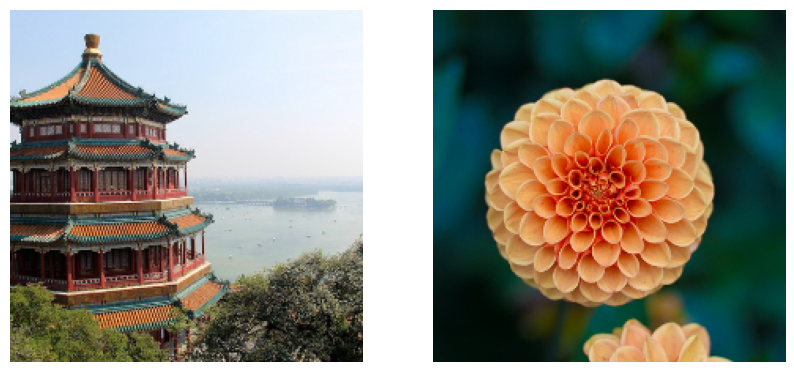

In [92]:
# extra code – displays the cropped and resized images

plt.figure(figsize=(10, 6))
for idx in (0, 1):
    plt.subplot(1, 2, idx + 1)
    plt.imshow(images_resized[idx] / 255)
    plt.axis("off")

plt.show()

In [76]:
top_K

[[('n03877845', 'palace', np.float32(0.54693675)),
  ('n03781244', 'monastery', np.float32(0.24714634)),
  ('n02825657', 'bell_cote', np.float32(0.18550415)),
  ('n02980441', 'castle', np.float32(0.0076988754)),
  ('n04346328', 'stupa', np.float32(0.0036479456))],
 [('n04522168', 'vase', np.float32(0.32669583)),
  ('n11939491', 'daisy', np.float32(0.17817384)),
  ('n03530642', 'honeycomb', np.float32(0.1204154)),
  ('n13040303', 'stinkhorn', np.float32(0.043312844)),
  ('n07930864', 'cup', np.float32(0.04210932))]]

## Pretrained Models for Transfer Learning

In [77]:
import tensorflow_datasets as tfds

dataset, info = tfds.load("tf_flowers", as_supervised=True, with_info=True)
dataset_size = info.splits["train"].num_examples # 3670
class_names = info.features["label"].names
n_classes = info.features["label"].num_classes

/Users/kevinkyhalim/ML_repo/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Dl Completed...: 100%|██████████| 1/1 [00:11<00:00, 11.10s/ url]
                                                                        

Dataset tf_flowers downloaded and prepared to /Users/kevinkyhalim/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [78]:
test_set_raw, valid_set_raw, train_set_raw = tfds.load(
    "tf_flowers",
    split=["train[:10%]", "train[10%:25%]", "train[25%:]"],
    as_supervised=True
)

2025-06-11 22:58:51.068961: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:387] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608
2025-06-11 22:58:51.125349: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2025-06-11 22:58:51.131507: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


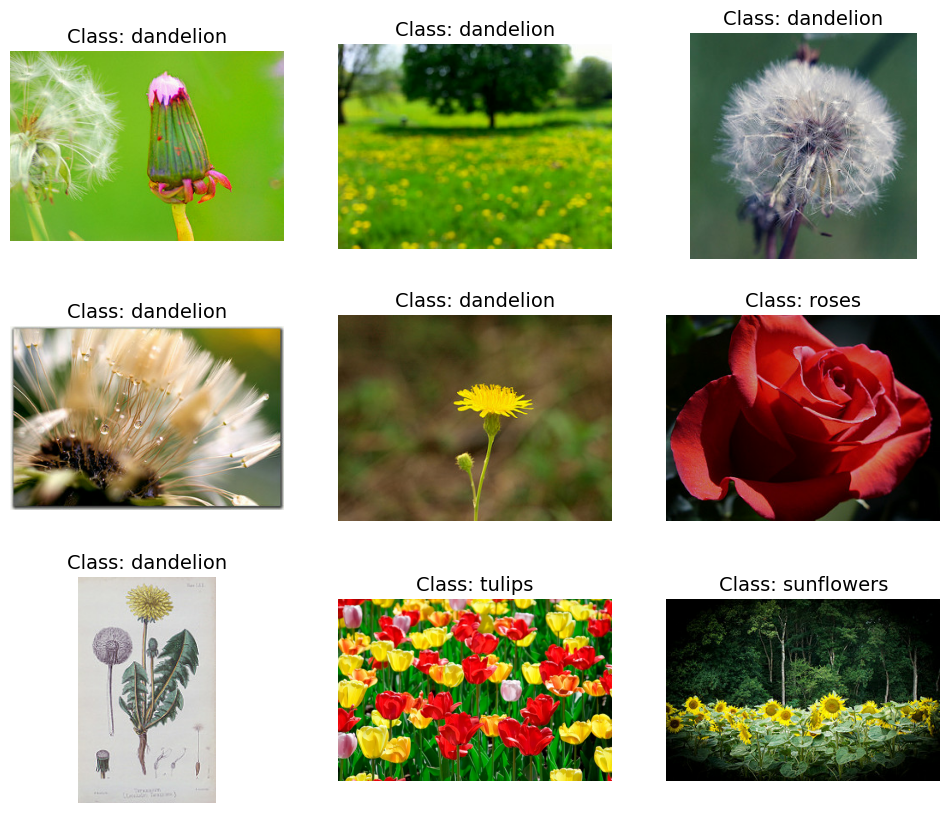

In [94]:
# extra code – displays the first 9 images in the validation set

plt.figure(figsize=(12, 10))
index = 0
for image, label in valid_set_raw.take(9):
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(image)
    plt.title(f"Class: {class_names[label]}")
    plt.axis("off")

plt.show()

In [82]:
batch_size=32
preprocess = tf.keras.Sequential([
    tf.keras.layers.Resizing(height=224, width=224, crop_to_aspect_ratio=True),
    tf.keras.layers.Lambda(tf.keras.applications.xception.preprocess_input)
])
train_set = train_set_raw.map(lambda X,y: (preprocess(X), y))
train_set = train_set.shuffle(1000, seed=42).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(lambda X,y:(preprocess(X), y)).batch(batch_size)
test_set = test_set_raw.map(lambda X,y:(preprocess(X), y)).batch(batch_size)

2025-06-11 22:59:37.062476: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


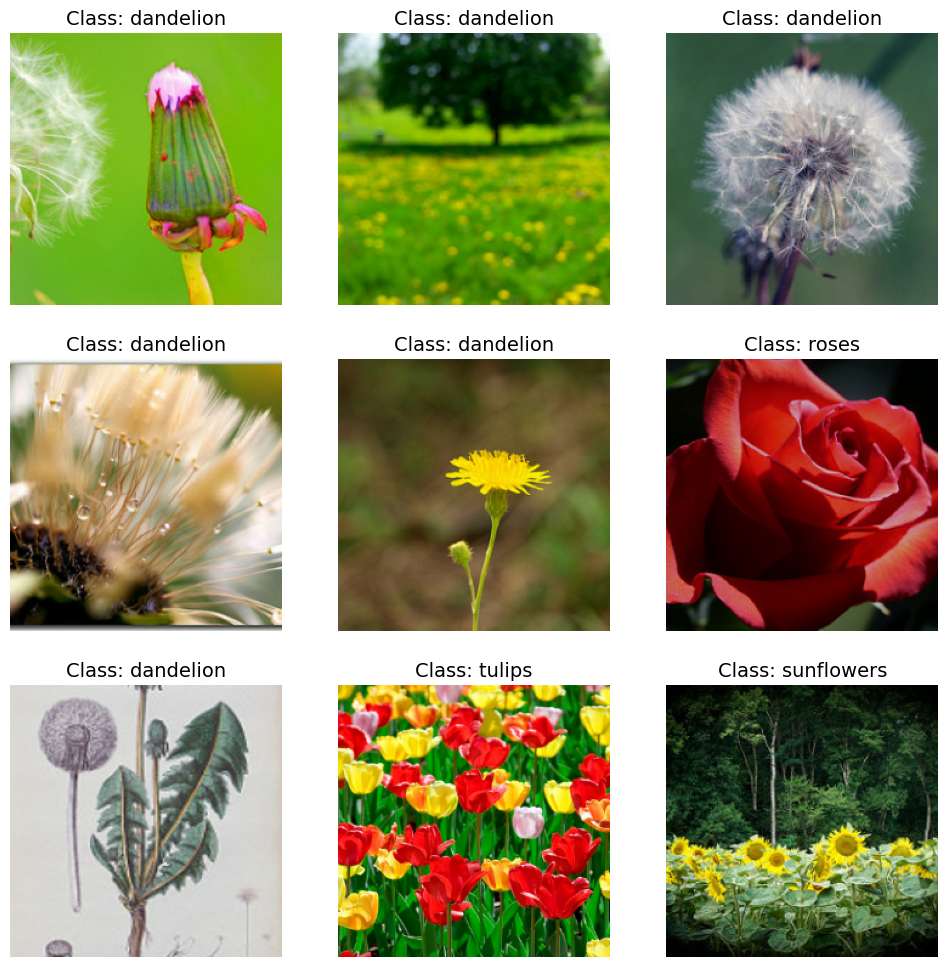

In [95]:
# extra code – displays the first 9 images in the first batch of valid_set

plt.figure(figsize=(12, 12))
for X_batch, y_batch in valid_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow((X_batch[index] + 1) / 2)  # rescale to 0–1 for imshow()
        plt.title(f"Class: {class_names[y_batch[index]]}")
        plt.axis("off")

plt.show()

In [83]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip(mode="horizontal", seed=42),
    tf.keras.layers.RandomRotation(factor = 0.05, seed = 42),
    tf.keras.layers.RandomContrast(factor = 0.2, seed=42)
])

In [85]:
# load the Xception model, but exclude the top layer
base_model = tf.keras.applications.xception.Xception(weights="imagenet",
                                                     include_top=False)
# add a global average pooling 2D on top of the Xception mode
avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
# add an output layer
output = tf.keras.layers.Dense(n_classes, activation="softmax")(avg)
model = tf.keras.Model(inputs = base_model.input, outputs=output)

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [ ]:
for layer in base_model.layers:
    layer.trainable=False

In [97]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set, validation_data=valid_set, epochs=3)

Epoch 1/3
86/86 ━━━━━━━━━━━━━━━━━━━━ 131s 1s/step - accuracy: 0.7088 - loss: 0.9233 - val_accuracy: 0.8639 - val_loss: 0.5861
Epoch 2/3
86/86 ━━━━━━━━━━━━━━━━━━━━ 124s 1s/step - accuracy: 0.9107 - loss: 0.3338 - val_accuracy: 0.8439 - val_loss: 0.6687
Epoch 3/3
86/86 ━━━━━━━━━━━━━━━━━━━━ 135s 2s/step - accuracy: 0.9317 - loss: 0.2171 - val_accuracy: 0.8457 - val_loss: 0.6169


In [98]:
for indices in zip(range(33), range(33, 66), range(66, 99), range(99, 132)):
    for idx in indices:
        print(f"{idx:3}: {base_model.layers[idx].name:22}", end="")
    print()

  0: input_layer_6          33: block4_pool            66: block8_sepconv1_act    99: block11_sepconv2_act  
  1: block1_conv1           34: batch_normalization_60 67: block8_sepconv1       100: block11_sepconv2      
  2: block1_conv1_bn        35: add_2                  68: block8_sepconv1_bn    101: block11_sepconv2_bn   
  3: block1_conv1_act       36: block5_sepconv1_act    69: block8_sepconv2_act   102: block11_sepconv3_act  
  4: block1_conv2           37: block5_sepconv1        70: block8_sepconv2       103: block11_sepconv3      
  5: block1_conv2_bn        38: block5_sepconv1_bn     71: block8_sepconv2_bn    104: block11_sepconv3_bn   
  6: block1_conv2_act       39: block5_sepconv2_act    72: block8_sepconv3_act   105: add_9                 
  7: block2_sepconv1        40: block5_sepconv2        73: block8_sepconv3       106: block12_sepconv1_act  
  8: block2_sepconv1_bn     41: block5_sepconv2_bn     74: block8_sepconv3_bn    107: block12_sepconv1      
  9: block2_sepconv

Now that the weights of our new top layers are not too bad, we can make the top part of the base model trainable again, and continue training, but with a lower learning rate:

In [99]:
for layer in base_model.layers[56:]:
    layer.trainable = True

optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set, validation_data=valid_set, epochs=10)

Epoch 1/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 269s 3s/step - accuracy: 0.8677 - loss: 0.3954 - val_accuracy: 0.8693 - val_loss: 0.6081
Epoch 2/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 265s 3s/step - accuracy: 0.9826 - loss: 0.0692 - val_accuracy: 0.9056 - val_loss: 0.3847
Epoch 3/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 283s 3s/step - accuracy: 0.9945 - loss: 0.0160 - val_accuracy: 0.9147 - val_loss: 0.3496
Epoch 4/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 271s 3s/step - accuracy: 0.9960 - loss: 0.0114 - val_accuracy: 0.9020 - val_loss: 0.3268
Epoch 5/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 286s 3s/step - accuracy: 0.9978 - loss: 0.0061 - val_accuracy: 0.9220 - val_loss: 0.2873
Epoch 6/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 257s 3s/step - accuracy: 0.9975 - loss: 0.0046 - val_accuracy: 0.9256 - val_loss: 0.2846
Epoch 7/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 261s 3s/step - accuracy: 0.9984 - loss: 0.0041 - val_accuracy: 0.9238 - val_loss: 0.3155
Epoch 8/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 272s 3s/step - accuracy: 0.9997 - loss: 0.0014 - val_accuracy: 0.9256 - v

## Classification and Localization

Localizing = predict a bounding box around the object, where a common approhac is to predict the horizontal and vertical coordinates of the object's center, as well as its height and width (4 numbers to predict).

In [104]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
base_model = tf.keras.applications.xception.Xception(weights="imagenet",
                                                     include_top=False)
avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
class_output = tf.keras.layers.Dense(n_classes, activation="softmax")(avg)
loc_output = tf.keras.layers.Dense(4)(avg)
model = tf.keras.Model(inputs=base_model.input,
                       outputs=[class_output, loc_output])
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)  # added this line
model.compile(loss=["sparse_categorical_crossentropy", "mse"],
              loss_weights=[0.8, 0.2],  # depends on what you care most about
              optimizer=optimizer, metrics=["accuracy", "mse"])

In [105]:
# extra code – fits the model using random target bounding boxes (in real life
#              you would need to create proper targets instead)

def add_random_bounding_boxes(images, labels):
    fake_bboxes = tf.random.uniform([tf.shape(images)[0], 4])
    return images, (labels, fake_bboxes)

fake_train_set = train_set.take(5).repeat(2).map(add_random_bounding_boxes)
model.fit(fake_train_set, epochs=2)

Epoch 1/2


10/10 ━━━━━━━━━━━━━━━━━━━━ 62s 5s/step - dense_10_accuracy: 0.2254 - dense_10_loss: 1.5950 - dense_11_loss: 0.3338 - dense_11_mse: 0.3338 - loss: 1.3428
Epoch 2/2
10/10 ━━━━━━━━━━━━━━━━━━━━ 52s 5s/step - dense_10_accuracy: 0.6470 - dense_10_loss: 1.1555 - dense_11_loss: 0.1954 - dense_11_mse: 0.1954 - loss: 0.9635


The MSE works fairly well as a cost function to train the model, but it is not a great metric to evaluate how well the model can predict bounding boxes. The most common metric for this is the *intersection over union* (IoU): the area of overlap between the predicted bounding box and the target bounding box, divided by the area of their union.

## Object Detection

Classifying and localizing multiple objects in an image.

In the past, a common approach was to take a CNN that was trained to classify and locate a single object roughly centered in the image, then slide this CNN across the image and make predictions at each step.

### Fully Convolutional Networks

Replacing the top of a CNN with a convolutional layer (rather than a dense layer). To do this, 
1. the number of filters in the convolutional layer must be equal to the number of units in the dense layer,
2. the filter size must be equal to the size of the input feature maps and
3. "valid" padding must be used.

Since a convolutional layer can process images of any size, it can be trained and executed on images of ANY size!

### You Only Look Once (YOLO)

Similar to FCN with differences such as:
1. For each grid cell, YOLO only considers objetcs whose bounding box center lies within that cell. The bounding box coordinates are relative to that cell, where (0,0) means the top-left corner of the cell and (1,1) means bottom right. However, the bounding box's height and width may extend well beyond the cell.
2. Outputs 2 bounding boxes for each grid cell, which allows the model to handle cases where 2 objects are so close to each other that their bounding box centers lie within the same cell.
3. Outputs a class probability distribution for each grid cell.

**Mean Average Precision**

Compute the MAXIMUM precision you can get with at increasing order of recall, then calculate the mean of these maximum percision, this is called the *average precision* (AP) metric. When there are > 2 classes, we can compute the AP for each class, and then compute the mean AP (mAP).

## Object Tracking

Most popular system is DeepSORT, based on a combination of classical algorithms and deep learing.

1. Uses *Kalman filters* to estimate the most likely current position of an object given prior detections, and assuming that objects tend to move at a constant speed.
2. Uses deep learning model to measure the resemblance between new detections and existing tracked objects.
3. Uses *Hungarian algorithm* to map new detections to existing tracked objects to efficiently find the combination of mappings that minimizes the distance between the detections and the predicted positions of tracked objects, while also minimizing the appearance discrepancy.

For example, imagine a red ball that just bounced off a blue ball traveling in the
opposite direction. Based on the previous positions of the balls, the Kalman filter will predict that the balls will go through each other: indeed, it assumes that objects move at a constant speed, so it will not expect the bounce. If the Hungarian algorithm only considered positions, then it would happily map the new detections to the wrong balls, as if they had just gone through each other and swapped colors. But thanks to the resemblance measure, the Hungarian algorithm will notice the problem. Assuming the balls are not too similar, the algorithm will map the new detections to the correct balls.


## Semantic Segmentation

Each pixel is classified according to the class of the object it belongs to! Note that different objects of the same class are NOT distinguised.

The main difficulty in this task is that when images go through a regular CNN, they gradually lose their spatial resolution (due to the layers with strides greater than 1); so a regular CNN may end up knowing there's a person somewhere in the bottom left of the image, but it will not be much more precise than that.

A fairly simple solution to object detection is with the FCN and added a single *upsampling layer* that multiplies the resolution by a specific amount, or also called *transposed convolutional layer*, where the image is stretched by inserting empty rows and columns (full of zeroes), then performing a regular convolution.

To further improve, they added a *skip connection* from lower layers: for example, they upsampled the output image by a factor of 2, then added the output of a lower layer that had this double resolution, and then upsample dht result by a factor of 16 to a total of upsampling factor of 32!

## Other topics

- Adversarial learning: make networks more resistant to images designed to fool it
- Explainability: understanding why the network makes a specific classification
- Realistic image generation
- Single shot learning
- Predicting the next frame in a video, etc